# Improve Predictions on Telecom Customer Churn

In this notebook, we test different models to predict customer churn, including Random Forest, Logistic Regression, XGBoost, and adjusting hyperparameters. 

Then we try different methods to improve these predictions. First, we try to test if "state" information has to do with churn. Then we try to precalculate certain measures and add these extra features to the dataset that eventually improved the predictions. Moreover, I divide the dataset into to subsets: without international plan and with international plan. I found that the Random Forest Model behaves differently on these two subsets. Further analysis on these subsets will give insights on how to attract customers to stay. 

## Contents

- 1 - [Data Cleaning](#sec1)
- 2 - [Random Forest and XGBoost](#sec2)
     - 2.1 - [Random Forest](#sec21)
     - 2.2 - [Hyperparameters](#sec22)
     - 2.3 - [XGBoost](#sec23)
- 3 - [Remove a Feature](#sec3)
- 4 - [Add Precalculated Features](#sec4)
- 5 - [Train Subsets Separately.](#sec5)
     - 5.1 - [Subset without international plan](#sec51)
     - 5.2 - [Subset with international plan](#sec52)
     - 5.3 - [Compare predictions of different models](#sec53)
- 6 - [Analysis and Conclusions](#sec6)

In [1]:
import numpy as np # Multi-dimensional array object
import pandas as pd # Data Manipulation
import matplotlib.pyplot as plt # Data Visualization
from sklearn.metrics import accuracy_score
import seaborn as sns # Data Visualizationcour
import plotly.express as px # Interactive Data Visualization
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot # Offline version of the Plotly modules.
import cufflinks as cf # Works as a connector between the pandas library and plotly
cf.go_offline() 
init_notebook_mode(connected=True) 

In [2]:
data = pd.read_csv('telecom.csv')

In [3]:
data.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

<a id = 'sec1'></a>
## 1. Data Cleaning

There are certain categorical features in this dateset, we transform them to numbers. 

In [5]:
#get all categorical columns
cat_columns = data.select_dtypes(['object']).columns

data[cat_columns] = data[cat_columns].apply(lambda x: pd.factorize(x)[0])

In [6]:
data.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,0,128,415,0,0,0,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,1,107,415,1,0,0,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,2,137,415,2,0,1,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,1,84,408,3,1,1,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,3,75,415,4,1,1,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [7]:
data['churn'] = pd.factorize(data['churn'])[0]

In [8]:
data.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,0,128,415,0,0,0,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,1,107,415,1,0,0,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,2,137,415,2,0,1,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,1,84,408,3,1,1,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,3,75,415,4,1,1,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


We don't need 'area code', 'phone number' in our analysis. These information has no direct relation to the customer churn. There are certain cases that customers just want to change phone number. But we don't consider such factor here. If necessary, later we may do another analysis on the influence of phone numbers (people may have favorite 'lucky number' etc). 

In [9]:
X = data.drop(columns = ['area code', 'phone number', 'churn'])
y = data['churn']

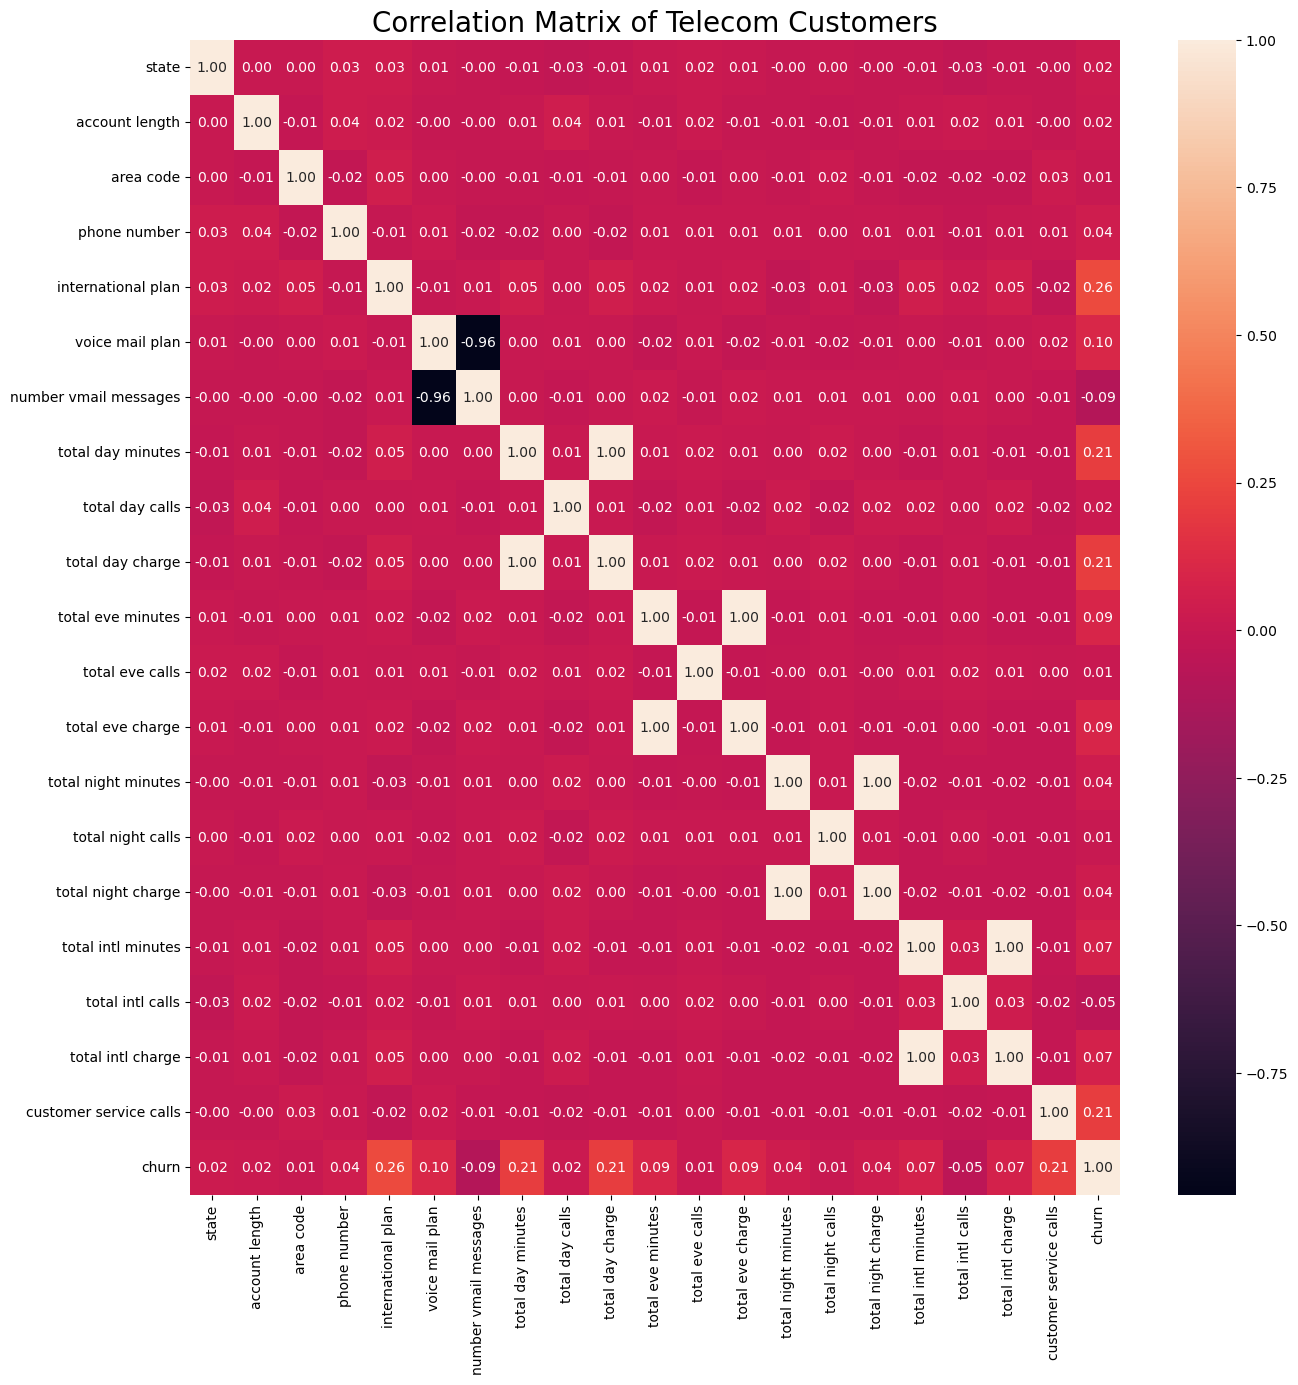

In [10]:
corr_matrix = data.corr()
plt.figure(figsize = (15, 15))

sns.heatmap(corr_matrix, annot = True, fmt = '0.2f')

plt.title("Correlation Matrix of Telecom Customers", fontsize = 20)
plt.show()

### Train Test Split
Now we split into train set and test set. 

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train.shape

(2666, 18)

<a id='sec2'></a>
## 2. Random Forest and XGBoost
<a id='sec21'></a>
### 2.1 First, we use Random Forest to predict churn. 

In [12]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

RandomForestClassifier()

In [13]:
y_predict = model_rf.predict(X_test)

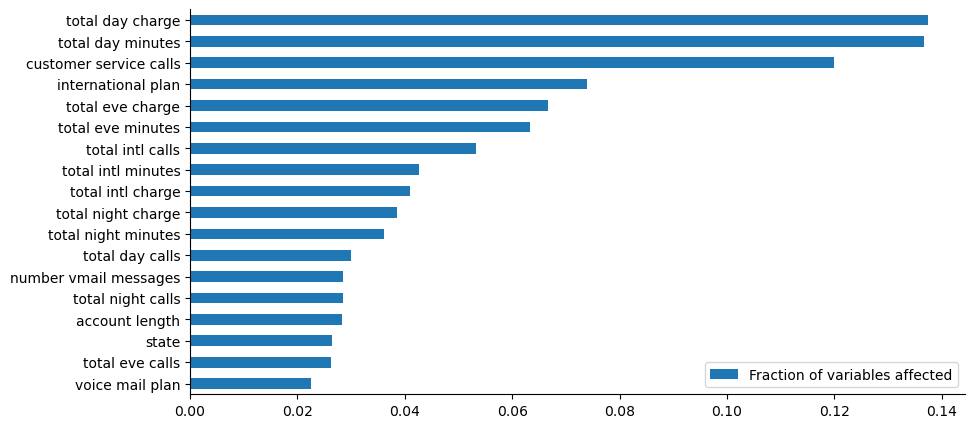

In [14]:
# Plot the feature importance

feat_scores= pd.DataFrame({"Fraction of variables affected" : model_rf.feature_importances_},index = X.columns)
feat_scores= feat_scores.sort_values(by = "Fraction of variables affected")
feat_scores.plot(kind = "barh", figsize = (10, 5))
sns.despine()

We take a look at the prediction precision. 

In [15]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       562
           1       0.95      0.71      0.82       105

    accuracy                           0.95       667
   macro avg       0.95      0.85      0.89       667
weighted avg       0.95      0.95      0.95       667



<Axes: >

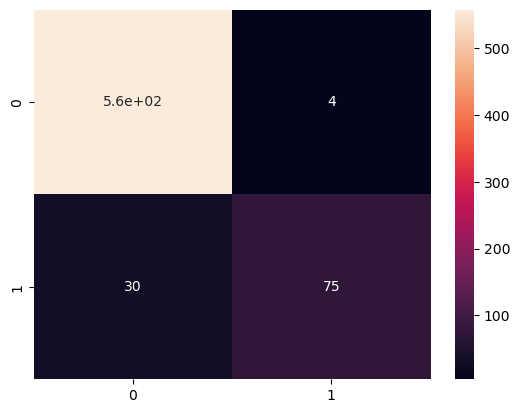

In [16]:
cm = confusion_matrix(y_test, y_predict)
sns.heatmap(cm, annot = True)

<a id='sec22'></a>
### 2.2 Now we do further analysis on hyperparameters.

In [17]:
min_samples_split_list = [2,8, 10,12, 20, 30, 50, 100, 200, 300, 700]  ## If the number is an integer, then it is the actual quantity of samples,
                                             ## If it is a float, then it is the percentage of the dataset
max_depth_list = [2, 4,5, 6, 7,8, 10, 16, 32, 64, None]
n_estimators_list = [10,50,100,500]
RANDOM_STATE = 50

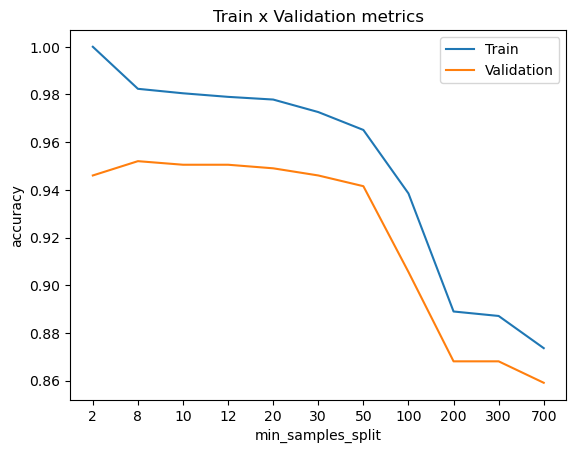

In [18]:
accuracy_list_train = []
accuracy_list_val = []
for min_samples_split in min_samples_split_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(min_samples_split = min_samples_split,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_test) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_test)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list) 
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

We may choose min_samples_split = 10. Next, we look at the max_depth

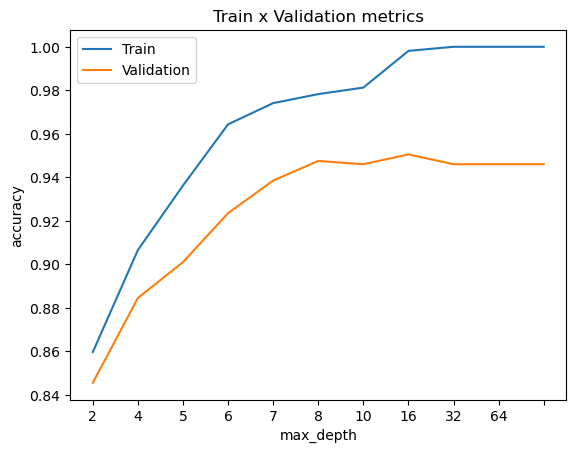

In [19]:
accuracy_list_train = []
accuracy_list_val = []
for max_depth in max_depth_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(max_depth = max_depth,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_test) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_test)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

We may choose max_depth=10. Then we look at the number of estimators. 

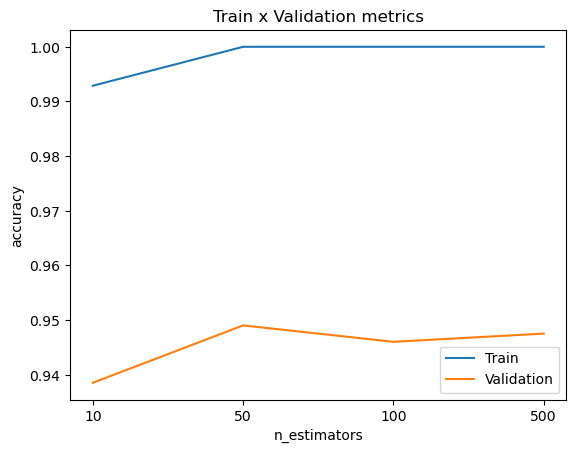

In [20]:
accuracy_list_train = []
accuracy_list_val = []
for n_estimators in n_estimators_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(n_estimators = n_estimators,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_test) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_test)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(n_estimators_list )),labels=n_estimators_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

Thus we choose n_estimators = 100.

Let's then fit a random forest with the following parameters:

 - max_depth: 10
 - min_samples_split: 10
 - n_estimators: 100

In [21]:
model_rf_hyper = RandomForestClassifier(n_estimators = 100,
                                             max_depth = 10, 
                                             min_samples_split = 10).fit(X_train,y_train)

In [22]:
y_hy_predict = model_rf_hyper.predict(X_test)

In [23]:
print('The accuracy score for the train set is:', accuracy_score(model_rf_hyper.predict(X_train),y_train))
print('The accuracy score for the test set is:', accuracy_score(model_rf_hyper.predict(X_test),y_test))

The accuracy score for the train set is: 0.978244561140285
The accuracy score for the test set is: 0.9460269865067467


In [24]:
print(classification_report(y_test, y_hy_predict))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       562
           1       0.93      0.71      0.81       105

    accuracy                           0.95       667
   macro avg       0.94      0.85      0.89       667
weighted avg       0.95      0.95      0.94       667



<Axes: >

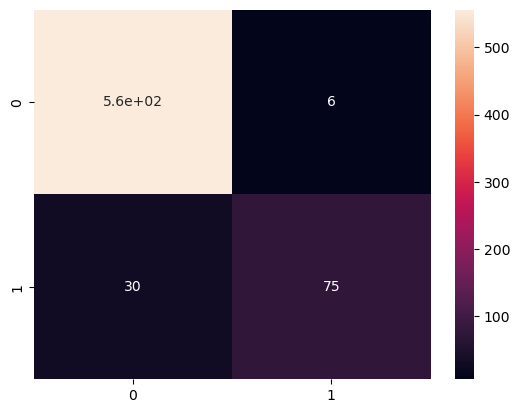

In [25]:
cm = confusion_matrix(y_test, model_rf_hyper.predict(X_test))
sns.heatmap(cm, annot = True)

We can see that after adjusting the hyperparameters, the prediction accuracy improved. Moreover, the previous model has problem of overfitting. 

<a id='sec23'></a>
### 2.3 XGBoost

In [26]:
n = int(len(X_train)*0.8) ## Let's use 80% to train and 20% to eval
X_train_fit, X_train_eval, y_train_fit, y_train_eval = X_train[:n], X_train[n:], y_train[:n], y_train[n:]

In [27]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators = 500, learning_rate = 0.1,verbosity = 1, random_state = RANDOM_STATE)
xgb_model.fit(X_train_fit,y_train_fit, eval_set = [(X_train_eval,y_train_eval)], early_stopping_rounds = 10)

[0]	validation_0-logloss:0.61548
[1]	validation_0-logloss:0.55237
[2]	validation_0-logloss:0.49906
[3]	validation_0-logloss:0.45388
[4]	validation_0-logloss:0.41639
[5]	validation_0-logloss:0.38321
[6]	validation_0-logloss:0.35420
[7]	validation_0-logloss:0.32947
[8]	validation_0-logloss:0.30814
[9]	validation_0-logloss:0.28939
[10]	validation_0-logloss:0.27311
[11]	validation_0-logloss:0.25846
[12]	validation_0-logloss:0.24662
[13]	validation_0-logloss:0.23495
[14]	validation_0-logloss:0.22459
[15]	validation_0-logloss:0.21623
[16]	validation_0-logloss:0.20788
[17]	validation_0-logloss:0.20002
[18]	validation_0-logloss:0.19375
[19]	validation_0-logloss:0.18812
[20]	validation_0-logloss:0.18274
[21]	validation_0-logloss:0.17924
[22]	validation_0-logloss:0.17452
[23]	validation_0-logloss:0.17092
[24]	validation_0-logloss:0.16840
[25]	validation_0-logloss:0.16533
[26]	validation_0-logloss:0.16275
[27]	validation_0-logloss:0.16087
[28]	validation_0-logloss:0.15899
[29]	validation_0-loglos

/Users/susanapfel/anaconda3/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[38]	validation_0-logloss:0.14900
[39]	validation_0-logloss:0.14777
[40]	validation_0-logloss:0.14785
[41]	validation_0-logloss:0.14726
[42]	validation_0-logloss:0.14688
[43]	validation_0-logloss:0.14647
[44]	validation_0-logloss:0.14582
[45]	validation_0-logloss:0.14566
[46]	validation_0-logloss:0.14503
[47]	validation_0-logloss:0.14514
[48]	validation_0-logloss:0.14533
[49]	validation_0-logloss:0.14524
[50]	validation_0-logloss:0.14472
[51]	validation_0-logloss:0.14401
[52]	validation_0-logloss:0.14340
[53]	validation_0-logloss:0.14263
[54]	validation_0-logloss:0.14233
[55]	validation_0-logloss:0.14221
[56]	validation_0-logloss:0.14230
[57]	validation_0-logloss:0.14180
[58]	validation_0-logloss:0.14239
[59]	validation_0-logloss:0.14259
[60]	validation_0-logloss:0.14230
[61]	validation_0-logloss:0.14193
[62]	validation_0-logloss:0.14179
[63]	validation_0-logloss:0.14204
[64]	validation_0-logloss:0.14194
[65]	validation_0-logloss:0.14199
[66]	validation_0-logloss:0.14187
[67]	validatio

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=50, ...)

In [28]:
xgb_model.best_iteration

68

In [29]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_test),y_test):.4f}")

Metrics train:
	Accuracy score: 0.9786
Metrics test:
	Accuracy score: 0.9415


In [30]:
print(classification_report(xgb_model.predict(X_test),y_test))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       579
           1       0.73      0.88      0.80        88

    accuracy                           0.94       667
   macro avg       0.86      0.91      0.88       667
weighted avg       0.95      0.94      0.94       667



<Axes: >

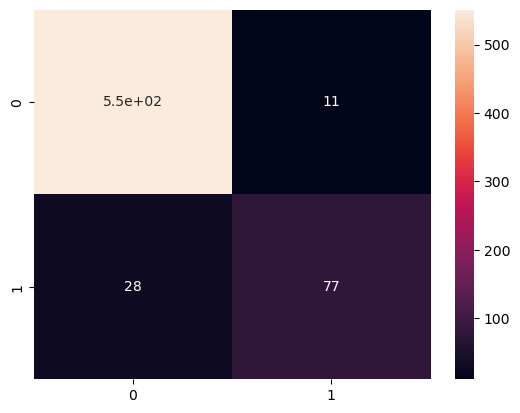

In [31]:
cm = confusion_matrix(y_test, xgb_model.predict(X_test))
sns.heatmap(cm, annot = True)

<a id='sec3'></a>
## 3. Remove a Feature

We try to do experiment by removing state information. 

In [32]:
X1_train = X_train.drop(columns = ['state'])
X1_test = X_test.drop(columns = ['state'])

In [33]:
X1_train.head()

,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
2187,167,0,1,0,169.2,124,28.76,173.3,108,14.73,216.5,64,9.74,12.4,4,3.35,4
728,86,0,0,39,261.2,122,44.40,214.2,101,18.21,154.9,101,6.97,12.7,5,3.43,2
2458,163,0,0,23,224.0,126,38.08,233.5,89,19.85,293.9,104,13.23,8.8,4,2.38,1
1548,102,0,1,0,271.1,80,46.09,172.0,133,14.62,169.2,105,7.61,10.3,5,2.78,1
296,74,0,1,0,85.7,83,14.57,247.7,67,21.05,142.4,85,6.41,10.1,5,2.73,2


In [34]:
model_rf_re = RandomForestClassifier()
model_rf_re.fit(X1_train, y_train)

RandomForestClassifier()

In [35]:
print(classification_report(y_test, model_rf_re.predict(X1_test)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       562
           1       0.93      0.73      0.82       105

    accuracy                           0.95       667
   macro avg       0.94      0.86      0.89       667
weighted avg       0.95      0.95      0.95       667



<Axes: >

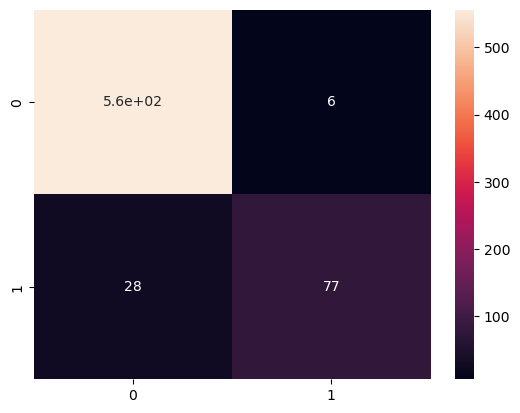

In [36]:
cm = confusion_matrix(y_test, model_rf_re.predict(X1_test))
sns.heatmap(cm, annot = True)

### Now we compare the previous models. 

In [37]:
# ROC curve
from sklearn.metrics import roc_curve

fpr1, tpr1, thresh1 = roc_curve(y_test, model_rf.predict_proba(X_test)[:, 1], pos_label = 1)
fpr2, tpr2, thresh2 = roc_curve(y_test, model_rf_hyper.predict_proba(X_test)[:, 1], pos_label = 1)
fpr3, tpr3, thresh3 = roc_curve(y_test, xgb_model.predict_proba(X_test)[:, 1], pos_label = 1)
fpr4, tpr4, thresh4 = roc_curve(y_test, model_rf_re.predict_proba(X1_test)[:, 1], pos_label = 1)


In [38]:
from sklearn.metrics import roc_auc_score

auc_score1 = roc_auc_score(y_test, model_rf.predict_proba(X_test)[:, 1])
auc_score2 = roc_auc_score(y_test, model_rf_hyper.predict_proba(X_test)[:, 1])
auc_score3 = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])
auc_score4 = roc_auc_score(y_test, model_rf_re.predict_proba(X1_test)[:, 1])

print("Random Forest: ", auc_score1) 
print("Random Forest with Hyperparameters: ", auc_score2) 
print("XGBoost: ", auc_score3) 
print("Random Forest without State Information: ", auc_score4) 

Random Forest:  0.8976698864599221
Random Forest with Hyperparameters:  0.900288086764955
XGBoost:  0.9084561938654466
Random Forest without State Information:  0.8957888493475683


We see that without including state information, the model behaves better. 

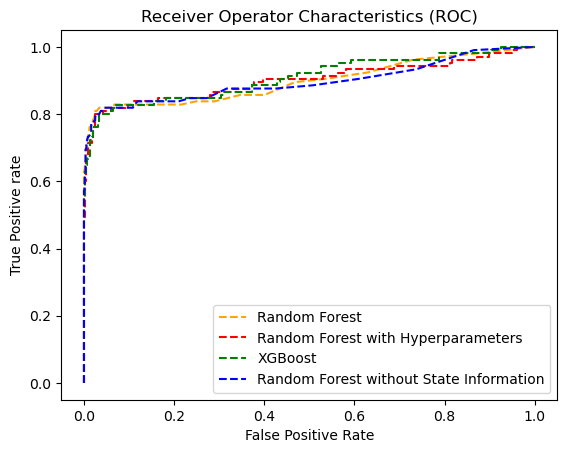

In [39]:
plt.plot(fpr1, tpr1, linestyle = "--", color = "orange", label = "Random Forest")
plt.plot(fpr2, tpr2, linestyle = "--", color = "red", label = "Random Forest with Hyperparameters")
plt.plot(fpr3, tpr3, linestyle = "--", color = "green", label = "XGBoost")
plt.plot(fpr4, tpr4, linestyle = "--", color = "blue", label = "Random Forest without State Information")

plt.title('Receiver Operator Characteristics (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc = 'best')
plt.savefig('ROC', dpi = 300)
plt.show()

<a id='sec4'></a>
## 4. Add Precalculated Features

In this dataset, we see features "today day minutes" and "total day calls", if we calculate the ratio of them, 

<h3><center>today day minutes / total day calls</center></h3>

i.e. average minutes for each call, which is a factor to show the use habit of a person. Hence we add this ratio to our dataset. 

Another factor to consider is the total charges, 
<h3><center>todal day charge + total eve charge + total night charge.</center></h3>
This total charge is not showing in this dataset. However, it may have a great contribution to the prediction of churn. For example, each item is cheap enough for me to buy, if we add a lof cheap items together, it could be very expensive. Then I prefer not to buy them together. Hence the total charge is an important factor. 

In [40]:
X_train.head()

,state,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
2187,40,167,0,1,0,169.2,124,28.76,173.3,108,14.73,216.5,64,9.74,12.4,4,3.35,4
728,46,86,0,0,39,261.2,122,44.40,214.2,101,18.21,154.9,101,6.97,12.7,5,3.43,2
2458,7,163,0,0,23,224.0,126,38.08,233.5,89,19.85,293.9,104,13.23,8.8,4,2.38,1
1548,29,102,0,1,0,271.1,80,46.09,172.0,133,14.62,169.2,105,7.61,10.3,5,2.78,1
296,43,74,0,1,0,85.7,83,14.57,247.7,67,21.05,142.4,85,6.41,10.1,5,2.73,2


In [41]:
X2_train = X_train.copy()
X2_test = X_test.copy()
y2_train = y_train.copy()
y2_test = y_test.copy()

X2_train['mincallratio']=X2_train.apply(lambda x: x['total day minutes'] / (x['total day calls']+0.1), axis=1) # add 0.1 to avoid dividing by 0
X2_train['evemincallratio']=X2_train.apply(lambda x: x['total eve minutes'] / (x['total eve calls']+0.1), axis=1)
X2_train['nightmincallratio']=X2_train.apply(lambda x: x['total night minutes'] / (x['total night calls']+0.1), axis=1)
X2_train['total charge']=X2_train.apply(lambda x: x['total day charge'] + x['total night charge'] + x['total eve charge'] + x['total intl charge'], axis=1)

X2_test['mincallratio']=X2_test.apply(lambda x: x['total day minutes'] / (x['total day calls']+0.1), axis=1)
X2_test['evemincallratio']=X2_test.apply(lambda x: x['total eve minutes'] / (x['total eve calls']+0.1), axis=1)
X2_test['nightmincallratio']=X2_test.apply(lambda x: x['total night minutes'] / (x['total night calls']+0.1), axis=1)
X2_test['total charge']=X2_test.apply(lambda x: x['total day charge'] + x['total night charge'] + x['total eve charge'] + x['total intl charge'], axis=1)



In [42]:
X2_train.head()

,state,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,...,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,mincallratio,evemincallratio,nightmincallratio,total charge
2187,40,167,0,1,0,169.2,124,28.76,173.3,108,...,64,9.74,12.4,4,3.35,4,1.363417,1.603145,3.377535,56.58
728,46,86,0,0,39,261.2,122,44.40,214.2,101,...,101,6.97,12.7,5,3.43,2,2.139230,2.118694,1.532146,73.01
2458,7,163,0,0,23,224.0,126,38.08,233.5,89,...,104,13.23,8.8,4,2.38,1,1.776368,2.620651,2.823247,73.54
1548,29,102,0,1,0,271.1,80,46.09,172.0,133,...,105,7.61,10.3,5,2.78,1,3.384519,1.292261,1.609895,71.10
296,43,74,0,1,0,85.7,83,14.57,247.7,67,...,85,6.41,10.1,5,2.73,2,1.031288,3.691505,1.673325,44.76


### Now we train this model using Random Forest.

In [43]:
model_rf_add = RandomForestClassifier()
model_rf_add.fit(X2_train, y2_train)

RandomForestClassifier()

In [44]:
print(classification_report(y2_test, model_rf_add.predict(X2_test)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       562
           1       1.00      0.79      0.88       105

    accuracy                           0.97       667
   macro avg       0.98      0.90      0.93       667
weighted avg       0.97      0.97      0.97       667



### The accuracy increased a lot!

<Axes: >

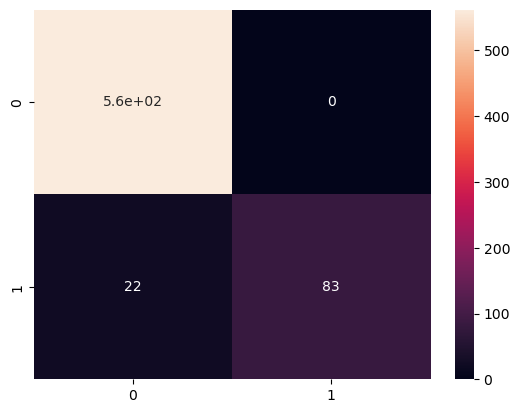

In [45]:
cm = confusion_matrix(y2_test, model_rf_add.predict(X2_test) )
sns.heatmap(cm, annot = True)

### Not only the accuracy increased, but also we get further information. We see that "False Negative" is zero, but there are many "False Positive", probably due to the effect of total charges. Acutally this is better for our business. We should pay attention on customers with potential churn. A large total charges might cause our customers to leave in the future.  We cannot see this effect if only consider the small charges piecewisely. Since we found this information, it's better to further detailed analysis on our customers. 

<a id='sec5'></a>
## 5. Train Subsets Separately.

In this section, we consider customers with international plan and without separately. And we compare the results with our previous models. 

Because we have to connect with the churn informaion. So we add this information first, then split into two groups. Before the training we will drop the 'churn' information from our train and test sets.  

In [46]:
X2_train['churn'] = y2_train
X2_test['churn'] = y2_test

<a id='sec51'></a>
### 5.1 The subset without international plan. 

In [47]:
X20_train = X2_train[X2_train['international plan']==0]
X20_test = X2_test[X2_test['international plan']==0]

In [48]:
y20_train = X20_train['churn']
y20_test = X20_test['churn']

In [49]:
dfeature = ['international plan',  'total day calls', 'total eve calls', 'total night calls', 'churn']
X20_train = X20_train.drop(dfeature, axis=1)
X20_test = X20_test.drop(dfeature, axis=1)
#print(X20_train.shape)
#print(X20_test.shape)

In [50]:
X20_train.head()

,state,account length,voice mail plan,number vmail messages,total day minutes,total day charge,total eve minutes,total eve charge,total night minutes,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,mincallratio,evemincallratio,nightmincallratio,total charge
2187,40,167,1,0,169.2,28.76,173.3,14.73,216.5,9.74,12.4,4,3.35,4,1.363417,1.603145,3.377535,56.58
728,46,86,0,39,261.2,44.40,214.2,18.21,154.9,6.97,12.7,5,3.43,2,2.139230,2.118694,1.532146,73.01
2458,7,163,0,23,224.0,38.08,233.5,19.85,293.9,13.23,8.8,4,2.38,1,1.776368,2.620651,2.823247,73.54
1548,29,102,1,0,271.1,46.09,172.0,14.62,169.2,7.61,10.3,5,2.78,1,3.384519,1.292261,1.609895,71.10
296,43,74,1,0,85.7,14.57,247.7,21.05,142.4,6.41,10.1,5,2.73,2,1.031288,3.691505,1.673325,44.76


In [51]:
y20_train.head()

2187    1
728     0
2458    0
1548    0
296     0
Name: churn, dtype: int64

In [52]:
model_rf20 = RandomForestClassifier()
model_rf20.fit(X20_train, y20_train)

RandomForestClassifier()

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       535
           1       1.00      0.77      0.87        77

    accuracy                           0.97       612
   macro avg       0.98      0.88      0.93       612
weighted avg       0.97      0.97      0.97       612



<Axes: >

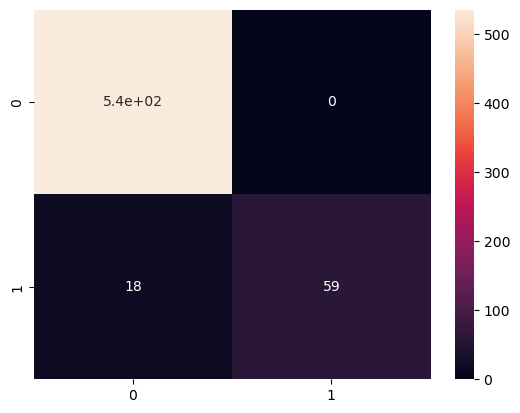

In [53]:
print(classification_report(y20_test, model_rf20.predict(X20_test)))
cm = confusion_matrix(y20_test, model_rf20.predict(X20_test))
sns.heatmap(cm, annot = True)

Recall our original Random Forest Model, we see improvement on this subset. Similar as above, we have zero "False Negative". It is better than having zero "False Positive" in which case we don't know the customers who are potentially to leave. 

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       562
           1       0.95      0.71      0.82       105

    accuracy                           0.95       667
   macro avg       0.95      0.85      0.89       667
weighted avg       0.95      0.95      0.95       667



<Axes: >

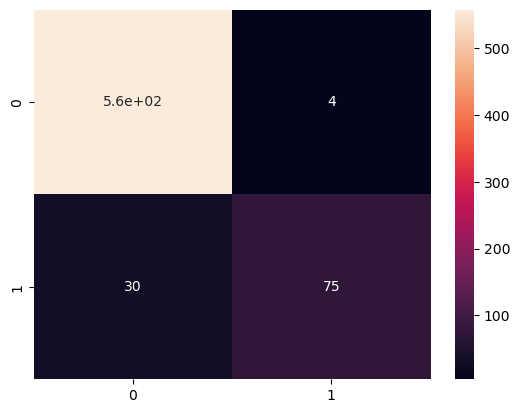

In [54]:
print(classification_report(y_test, model_rf.predict(X_test)))
cm = confusion_matrix(y_test, model_rf.predict(X_test))
sns.heatmap(cm, annot = True)

<a id='sec52'></a>
### 5.2 Now we look at the subset with international plan. 

In [55]:
X21_train = X2_train[X2_train['international plan']==1]
X21_test = X2_test[X2_test['international plan']==1]

y21_train = X21_train['churn']
y21_test = X21_test['churn']

In [56]:
dfeature = ['international plan',  'total day calls', 'total eve calls', 'total night calls', 'churn']
X21_train = X21_train.drop(columns=dfeature)
X21_test = X21_test.drop(columns=dfeature)
print(X21_train.shape)
print(X21_test.shape)

(268, 18)
(55, 18)


In [57]:
X21_train.head()

,state,account length,voice mail plan,number vmail messages,total day minutes,total day charge,total eve minutes,total eve charge,total night minutes,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,mincallratio,evemincallratio,nightmincallratio,total charge
1651,49,64,1,0,225.3,38.30,108.2,9.20,139.6,6.28,17.3,9,4.67,1,1.680089,1.242250,1.056775,58.45
3157,30,127,1,0,143.2,24.34,179.5,15.26,171.8,7.73,6.2,4,1.67,4,2.382696,1.128221,1.407043,49.00
3246,39,77,0,44,103.2,17.54,236.3,20.09,203.5,9.16,11.9,2,3.21,0,0.881298,2.744483,2.012859,50.00
2194,34,136,0,29,85.2,14.48,230.4,19.58,243.6,10.96,9.0,3,2.43,2,0.868502,2.707403,2.340058,47.45
2549,25,79,1,0,103.5,17.60,319.3,27.14,239.9,10.80,8.4,4,2.27,2,0.771812,2.873987,1.933118,57.81


In [58]:
model_rf21 = RandomForestClassifier()
model_rf21.fit(X21_train, y21_train)

RandomForestClassifier()

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        27
           1       0.96      0.96      0.96        28

    accuracy                           0.96        55
   macro avg       0.96      0.96      0.96        55
weighted avg       0.96      0.96      0.96        55



<Axes: >

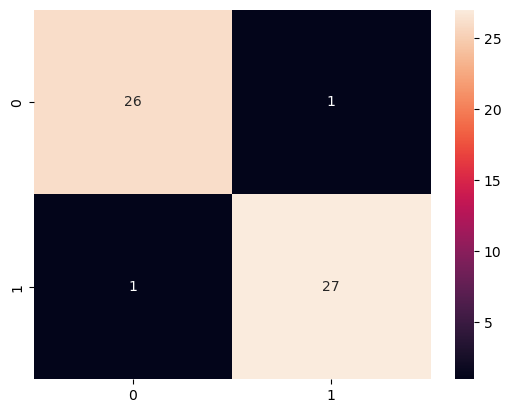

In [59]:
print(classification_report(y21_test, model_rf21.predict(X21_test)))
cm = confusion_matrix(y21_test, model_rf21.predict(X21_test))
sns.heatmap(cm, annot = True)

### This subset also has very high prediction accuracy!

In [60]:
X2_train = X2_train.drop(columns =['churn'])
X2_test = X2_test.drop(columns =['churn'])

In [61]:
X2_test.head()

,state,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,...,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,mincallratio,evemincallratio,nightmincallratio,total charge
3053,36,82,0,1,0,199.3,112,33.88,193.4,120,...,117,11.45,7.0,10,1.89,0,1.777877,1.610325,2.172502,63.66
1694,15,99,0,1,0,115.5,75,19.64,218.1,111,...,98,11.47,11.5,7,3.11,7,1.537949,1.963096,2.598369,52.76
656,37,55,0,1,0,175.6,147,29.85,161.8,118,...,55,13.03,9.3,4,2.51,0,1.193746,1.370025,5.254083,59.14
1242,50,136,1,1,0,256.8,90,43.66,230.1,104,...,82,6.46,9.1,10,2.46,3,2.850166,2.210375,1.749086,72.14
2347,25,68,1,0,29,195.5,113,33.24,171.6,96,...,85,9.18,13.5,9,3.65,1,1.728559,1.785640,2.397180,60.66


<a id='sec53'></a>
### 5.3 Now we compare all the previous models.

In [62]:
# ROC curve
from sklearn.metrics import roc_curve

fpr1, tpr1, thresh1 = roc_curve(y_test, model_rf.predict_proba(X_test)[:, 1], pos_label = 1)
fpr2, tpr2, thresh2 = roc_curve(y_test, model_rf_hyper.predict_proba(X_test)[:, 1], pos_label = 1)
fpr3, tpr3, thresh3 = roc_curve(y_test, xgb_model.predict_proba(X_test)[:, 1], pos_label = 1)
fpr4, tpr4, thresh4 = roc_curve(y_test, model_rf_re.predict_proba(X1_test)[:, 1], pos_label = 1)
fpr5, tpr5, thresh5 = roc_curve(y2_test, model_rf_add.predict_proba(X2_test)[:, 1], pos_label = 1)
fpr6, tpr6, thresh6 = roc_curve(y20_test, model_rf20.predict_proba(X20_test)[:, 1], pos_label = 1)
fpr7, tpr7, thresh7 = roc_curve(y21_test, model_rf21.predict_proba(X21_test)[:, 1], pos_label = 1)

In [63]:
from sklearn.metrics import roc_auc_score

auc_score1 = roc_auc_score(y_test, model_rf.predict_proba(X_test)[:, 1])
auc_score2 = roc_auc_score(y_test, model_rf_hyper.predict_proba(X_test)[:, 1])
auc_score3 = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])
auc_score4 = roc_auc_score(y_test, model_rf_re.predict_proba(X1_test)[:, 1])
auc_score5 = roc_auc_score(y2_test, model_rf_add.predict_proba(X2_test)[:, 1])
auc_score6 = roc_auc_score(y20_test, model_rf20.predict_proba(X20_test)[:, 1])
auc_score7 = roc_auc_score(y21_test, model_rf21.predict_proba(X21_test)[:, 1])


print("Random Forest: ", auc_score1) 
print("Random Forest with Hyperparameters: ", auc_score2) 
print("XGBoost: ", auc_score3) 
print("Random Forest without State Information: ", auc_score4) 
print("Random Forest with Added Feature: ", auc_score5) 
print("Random Forest with Added Feature - withouth International Plan: ", auc_score6) 
print("Random Forest with Added Feature - with International Plan: ", auc_score7) 

Random Forest:  0.8976698864599221
Random Forest with Hyperparameters:  0.900288086764955
XGBoost:  0.9084561938654466
Random Forest without State Information:  0.8957888493475683
Random Forest with Added Feature:  0.9033892560582952
Random Forest with Added Feature - withouth International Plan:  0.8677873528340818
Random Forest with Added Feature - with International Plan:  0.9986772486772487


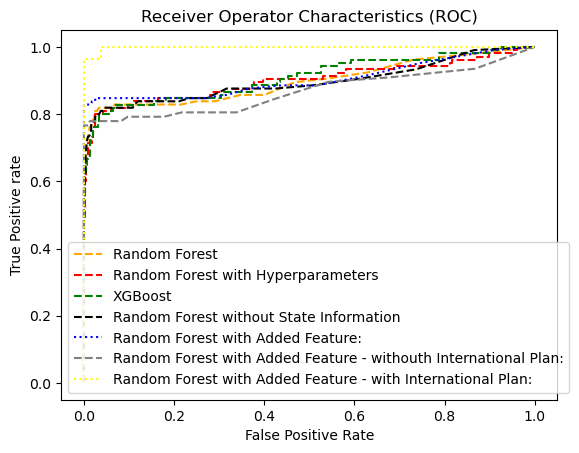

In [64]:
plt.plot(fpr1, tpr1, linestyle = "--", color = "orange", label = "Random Forest")
plt.plot(fpr2, tpr2, linestyle = "--", color = "red", label = "Random Forest with Hyperparameters")
plt.plot(fpr3, tpr3, linestyle = "--", color = "green", label = "XGBoost")
plt.plot(fpr4, tpr4, linestyle = "--", color = "black", label = "Random Forest without State Information")
plt.plot(fpr5, tpr5, linestyle = "dotted", color = "blue", label = "Random Forest with Added Feature: ")
plt.plot(fpr6, tpr6, linestyle = "--", color = "gray", label = "Random Forest with Added Feature - withouth International Plan:")
plt.plot(fpr7, tpr7, linestyle = "dotted", color = "yellow", label = "Random Forest with Added Feature - with International Plan:")


plt.title('Receiver Operator Characteristics (ROC)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')

plt.legend(loc = 'best')
plt.savefig('ROC', dpi = 300)
plt.show()

### Random Forest with Added Feature wins!

<a id='sec6'></a>
## 6. Analysis and Conclusions

In this beginning of our experiment, we tested the Random Forest Model and XGBoost Model. They already give very precise predictions. 

In order to improve the predictions, first we try to remove a feature 'state', the prediction increased somehow. Then we try to another strategy: adding features. We precalcualte certain factors which might affect the customer churn, for example, the average minutes per call, and total charges. After adding these features, the prediction accuracy improved, espeically that the 'False Negative' rate dropped to very low. 'False Postive' also decreased. 

For the subset case 'without international plan', it seems like there are high 'False Positive'. A reason for the 'False Positive' rate may be due to the new feature 'total charge' which might cause customers to churn. But this information tells us to pay attention on customers who might have less tolerance on high 'total charge'. Then in order to improve our profit, we could iniate more events for these group of people to keep them longer. 